<a href="https://colab.research.google.com/github/Gur07/SummerSchool25/blob/main/Day5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 13.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.86MB/s]


Epoch [1/10], Loss: 0.0583
Epoch [2/10], Loss: 0.0301
Epoch [3/10], Loss: 0.0245
Epoch [4/10], Loss: 0.0209
Epoch [5/10], Loss: 0.0186
Epoch [6/10], Loss: 0.0169
Epoch [7/10], Loss: 0.0155
Epoch [8/10], Loss: 0.0146
Epoch [9/10], Loss: 0.0137
Epoch [10/10], Loss: 0.0130


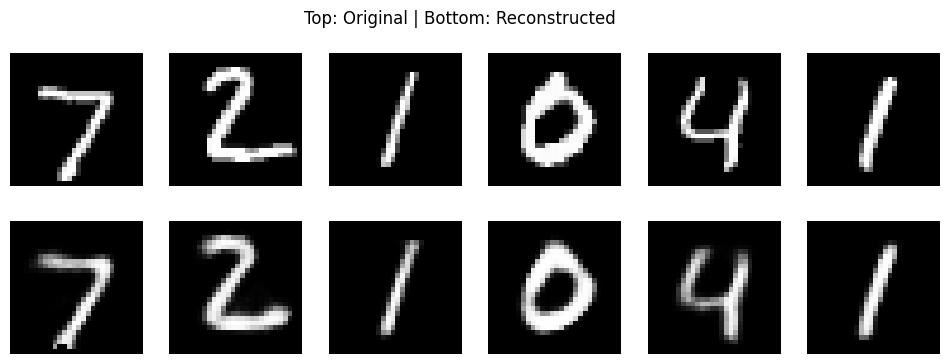

In [ ]:
# ==========================
# 🚀 1. Install & Import Libraries
# ==========================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ==========================
# 📦 2. Load and Transform MNIST Dataset
# ==========================
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

# ==========================
# 🧠 3. Define Autoencoder Architecture
# ==========================
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),                # 1x28x28 → 784
            nn.Linear(784, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32)           # Latent space (compressed)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 784),
            nn.Sigmoid(),               # To get pixel values between 0 and 1
            nn.Unflatten(1, (1, 28, 28))# 784 → 1x28x28
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder().to(device)

# ==========================
# ⚙️ 4. Define Loss Function and Optimizer
# ==========================
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==========================
# 🎯 5. Training Loop
# ==========================
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# ==========================
# 🔍 6. Visualize Original vs Reconstructed Images
# ==========================
def imshow(imgs1, imgs2, n=6):
    imgs1 = imgs1.cpu().detach().numpy()
    imgs2 = imgs2.cpu().detach().numpy()

    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        axes[0][i].imshow(imgs1[i].squeeze(), cmap='gray')
        axes[0][i].axis('off')
        axes[1][i].imshow(imgs2[i].squeeze(), cmap='gray')
        axes[1][i].axis('off')
    plt.suptitle("Top: Original | Bottom: Reconstructed")
    plt.show()

# Get some test images
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)
with torch.no_grad():
    reconstructed = model(test_images)
imshow(test_images, reconstructed)


Epoch [1/10], Loss: 176.0528
Epoch [2/10], Loss: 129.3362
Epoch [3/10], Loss: 119.4826
Epoch [4/10], Loss: 115.1464
Epoch [5/10], Loss: 112.5775
Epoch [6/10], Loss: 110.9674
Epoch [7/10], Loss: 109.9108
Epoch [8/10], Loss: 109.0434
Epoch [9/10], Loss: 108.4230
Epoch [10/10], Loss: 107.9070


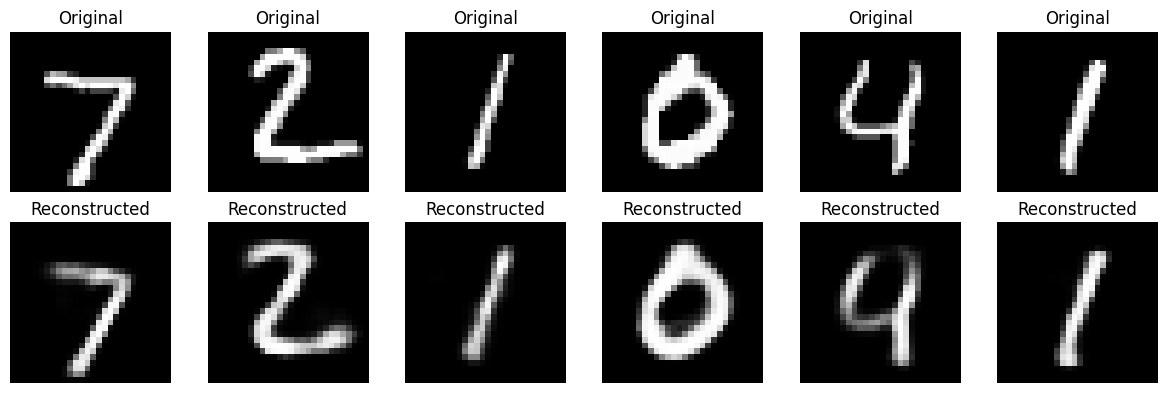

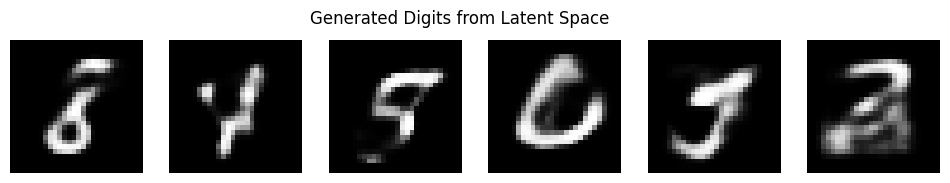

In [ ]:
# ==========================
# 🧠 3. Define VAE Model
# ==========================
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2_mu = nn.Linear(256, 32)
        self.fc2_logvar = nn.Linear(256, 32)

        # Decoder layers
        self.fc3 = nn.Linear(32, 256)
        self.fc4 = nn.Linear(256, 784)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # Reparameterization trick

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon.view(-1, 1, 28, 28), mu, logvar

# ==========================
# ⚙️ 4. Define Loss Function
# ==========================
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# ==========================
# 🏋️ 5. Train the VAE Model
# ==========================
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)

        recon, mu, logvar = vae(images)
        loss = vae_loss(recon, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# ==========================
# 👀 6. Visualize Original vs Reconstructed Images
# ==========================
def show_reconstruction():
    images, _ = next(iter(test_loader))
    images = images.to(device)
    with torch.no_grad():
        recon, _, _ = vae(images)

    images = images.cpu().numpy()
    recon = recon.cpu().numpy()

    fig, axes = plt.subplots(2, 6, figsize=(12, 4))
    for i in range(6):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

show_reconstruction()

# ==========================
# ✨ 7. Generate New Samples from Latent Space
# ==========================
def generate_samples():
    with torch.no_grad():
        z = torch.randn(6, 32).to(device)
        generated = vae.decode(z).view(-1, 1, 28, 28).cpu().numpy()

    plt.figure(figsize=(12, 2))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(generated[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle("Generated Digits from Latent Space")
    plt.show()

generate_samples()

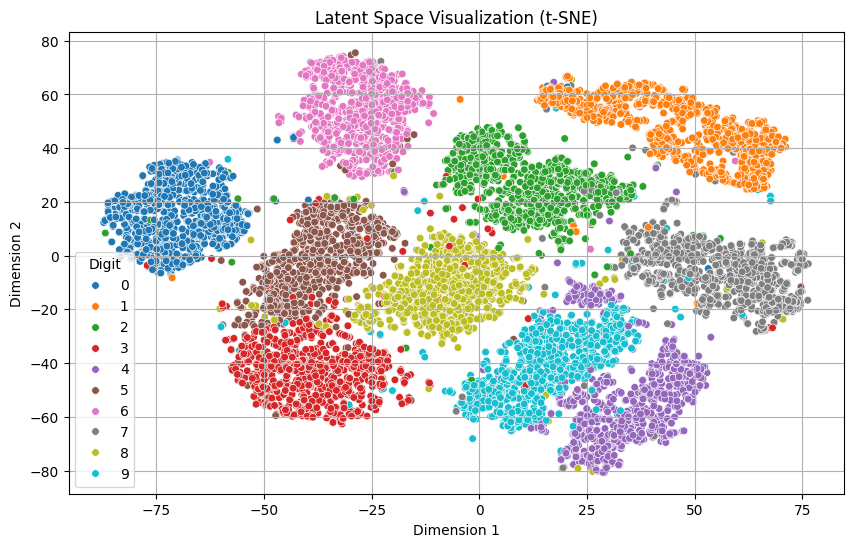

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Collect latent vectors
vae.eval()
latents = []
labels = []

with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        mu, _ = vae.encode(images.view(-1, 784))  # For VAE
        latents.append(mu.cpu())
        labels += targets.tolist()

latents = torch.cat(latents, dim=0).numpy()

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latents_2d = tsne.fit_transform(latents)

# Visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(x=latents_2d[:, 0], y=latents_2d[:, 1], hue=labels, palette='tab10', s=30)
plt.title("Latent Space Visualization (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title='Digit')
plt.grid(True)
plt.show()
